In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve
from itertools import product
from scipy.special import comb

In [2]:
np.set_printoptions(formatter={'float': '{: 0.5f}'.format})
DELTA = 0.0

n_agents = 2
tick_num = 10

weights = np.zeros(tick_num)
space = np.linspace(0.1, 1, tick_num)
weights = np.linspace(0.0, 0.1, tick_num)
sig = 0.1

In [3]:
kernel = weights / sig
np.exp(-kernel)

array([ 1.00000,  0.89484,  0.80074,  0.71653,  0.64118,  0.57375,
        0.51342,  0.45943,  0.41111,  0.36788])

In [4]:
weights

array([ 0.00000,  0.01111,  0.02222,  0.03333,  0.04444,  0.05556,
        0.06667,  0.07778,  0.08889,  0.10000])

In [5]:
# Theoretical limit with multi-agents and multi-actions on one-side
def margin(action):
    price = space[action]
    kernel = np.sum(weights[action])
    kernel = kernel / sig / n_agents
    arrival_prob = np.exp(-kernel)
    winner = np.where(price == price.min())
    return arrival_prob, winner, price.min() / len(winner[0])

def expected_reward(ask_action):
    # the first item in all actions is the player
    ask_prob, ask_winner, ask_reward = margin(ask_action)
    total_reward = np.zeros(n_agents)
    total_reward[ask_winner] += ask_reward * ask_prob
    return total_reward[0]

def Boltz(x):
    prob = np.exp(x / temper)
    prob = prob / np.sum(prob)
    return prob

def gen_act(C, ask_tick):
    ind = np.cumsum(C)
    action = np.zeros(n_agents)
    for k in reversed(range(len(ind))):
        action[1:ind[k] + 1] = k
    action[0] = ask_tick
    return action

act_count = [np.array(val) for val in product(range(n_agents), repeat=tick_num) if sum(val) == (n_agents - 1)]

def F(Q):
    # Q is the Q function with shape tick_num**2
    Prob = Boltz(Q)
    # Enumerate all possible actions for other agents beside self
    # reward multiplied by multinomial probabilities
    ER = np.zeros(tick_num)
    for ask_tick in range(tick_num):
        # Loop over actions of other agents
        for k in range(len(act_count)):
            C = act_count[k]
            # temp is multinomial probability
            temp = comb(n_agents - 1, C[0]) * np.power(Prob[0], C[0])
            for ab in range(1, tick_num):
                temp = temp * comb(n_agents - 1 - np.sum(C[:ab]), C[ab]) * np.power(Prob[ab], C[ab])
                action = gen_act(C, ask_tick).astype(int)
#                 ask_action = (action // tick_num).astype(int)
#                 bid_action = (action % tick_num).astype(int)
            ER[ask_tick] += temp * expected_reward(action)
    return ER + DELTA * np.max(Q) - Q

temper = 0.1
init = np.zeros(tick_num)
init[0] = 0.8
sol = fsolve(F, init)
print('Temperature', temper)
print('Q-values q*', sol)
print('Probability p*', Boltz(sol))
print('Residuals of contraction map', F(sol))

Temperature 0.1
Q-values q* [ 0.07827  0.12699  0.14209  0.13241  0.11140  0.08762  0.06462  0.04357
  0.02473  0.00800]
Probability p* [ 0.08780  0.14292  0.16620  0.15087  0.12228  0.09640  0.07659  0.06206
  0.05140  0.04348]
Residuals of contraction map [ 0.00000  0.00000  0.00000 -0.00000 -0.00000  0.00000  0.00000 -0.00000
 -0.00000 -0.00000]


In [6]:
R = np.zeros((tick_num, tick_num))
for i in range(tick_num):
    for j in range(tick_num):
        R[i, j] = expected_reward([i, j])

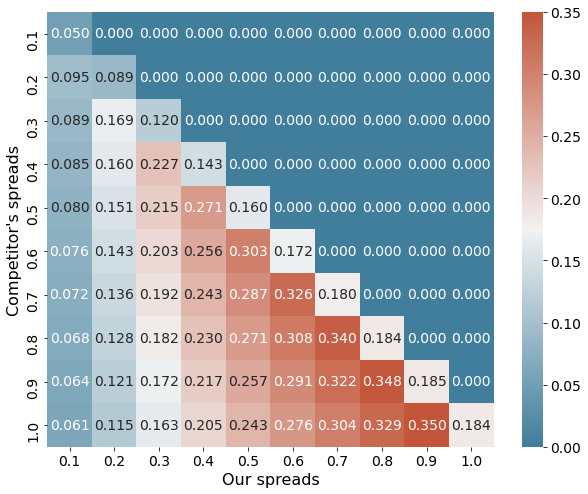

In [7]:
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
labels = ['{:,.1f}'.format(x) for x in space]
ax = sns.heatmap(R.transpose(), xticklabels=labels, yticklabels=labels, annot=True, fmt=".3f", 
                 annot_kws={"fontsize":14}, cmap=cmap)
# fig, ax = plt.subplots(figsize=(8,6))
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
plt.xlabel('Our spreads', fontsize=16)
plt.ylabel('Competitor\'s spreads', fontsize=16)
# cbar = ax.figure.colorbar(ax.collections[0])
cbar = ax.collections[0].colorbar
# here set the labelsize by 14
cbar.ax.tick_params(labelsize=14)
plt.savefig('multi_oneside.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)
# plt.show()